# **Multi-Model Ensemble Approach for Image Classification:** Enhancing Accuracy in Tom and Jerry Character Recognition

The project aims to improve the accuracy of character recognition in images from the classic cartoon series "Tom and Jerry" using a multi-model ensemble approach. By combining the predictions of two deep learning models, InceptionV3 and VGG16, we leverage the strengths of each model to create a more robust and accurate classifier. The ensemble model is trained and evaluated using a dataset containing images of Tom, Jerry, both characters, and background scenes. The ensemble model achieved an accuracy of **82%** on the validation dataset.

Group members:
* Kaneez E Zahra - 2022245
* Nauman Ali Murad - 20222479


# Importing the libraries

In [3]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import confusion_matrix
import seaborn as sns

# **Importing saved models from drive**

In [6]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [7]:
inception_trained = load_model("/content/drive/MyDrive/Colab Notebooks/CS251/inception_trained.keras")
vgg16_trained = load_model("/content/drive/MyDrive/Colab Notebooks/CS251/vgg16_trained.keras")

# **Data Preprocessing**

In [4]:
#Setting Constraints
IMAGE_DIRECTORY = "/kaggle/input/tom-and-jerry-image-classification/tom_and_jerry/tom_and_jerry/"
batch_size = 32
img_height = 75
img_width = 75


In [5]:
#Loading the dataset and splitting into training and validation sets
train_ds = tf.keras.utils.image_dataset_from_directory(
    IMAGE_DIRECTORY,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    IMAGE_DIRECTORY,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 5478 files belonging to 4 classes.
Using 4383 files for training.
Found 5478 files belonging to 4 classes.
Using 1095 files for validation.


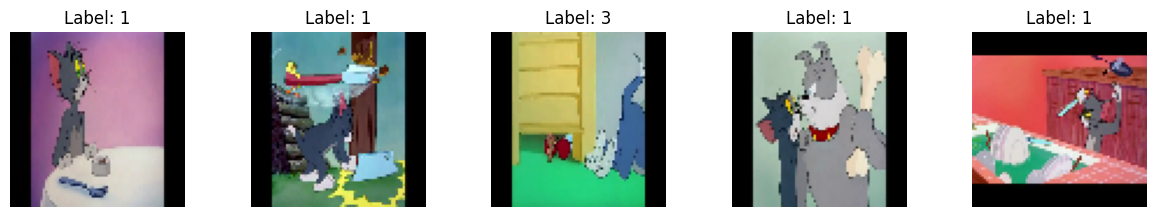

In [ ]:
# Print the first 10 images along with their corresponding labels
plt.figure(figsize=(15, 5))
for i, (images, labels) in enumerate(train_ds.take(1)):
    for j in range(5):
        ax = plt.subplot(2, 5, j + 1)
        plt.imshow(images[j].numpy().astype("uint8"))
        plt.title(f"Label: {labels[j].numpy()}")
        plt.axis("off")
plt.show()


In [ ]:
# Number of classes
num_classes = len(set(label for _, labels in train_ds for label in labels.numpy()))
print("Number of Classes:", num_classes)


Number of Classes: 4


In [ ]:
#Labeling categories
label_categories = {
    0: "Jerry",
    1: "Tom",
    2: "None",
    3: "Both"
}

In [ ]:
# Initialize dictionaries to store the counts of each class
train_class_counts = {label: 0 for label in label_categories.values()}
val_class_counts = {label: 0 for label in label_categories.values()}

# Count the occurrences of each class label in the training dataset
for _, labels in train_ds:
    for label in labels.numpy():
        train_class_counts[label_categories[label]] += 1

# Count the occurrences of each class label in the validation dataset
for _, labels in val_ds:
    for label in labels.numpy():
        val_class_counts[label_categories[label]] += 1

print("Training Dataset Class Counts:")
for label, count in train_class_counts.items():
    print(f"{label}: {count}")

print("\nValidation Dataset Class Counts:")
for label, count in val_class_counts.items():
    print(f"{label}: {count}")


Training Dataset Class Counts:
Jerry: 1022
Tom: 1530
None: 1216
Both: 615

Validation Dataset Class Counts:
Jerry: 218
Tom: 400
None: 312
Both: 165


# **Model Training**

In [ ]:
pre_trained_model = InceptionV3(input_shape = (75, 75, 3),
                                include_top = False,
                                weights = "imagenet")

# pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
     layer.trainable = False

# pre_trained_model.summary()
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(6, activation='softmax')(x)

model = Model(pre_trained_model.input, x)

model.compile(optimizer = RMSprop(learning_rate=0.0001),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['acc'])


87910968/87910968 [==============================] - 0s 0us/step
last layer output shape:  (None, 3, 3, 768)


In [ ]:
history=model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=25)

Epoch 1/25
137/137 [==============================] - 15s 103ms/step - loss: 1.0247 - acc: 0.5921 - val_loss: 1.0407 - val_acc: 0.5909
Epoch 2/25
137/137 [==============================] - 12s 85ms/step - loss: 0.9719 - acc: 0.6126 - val_loss: 0.9820 - val_acc: 0.6128
Epoch 3/25
137/137 [==============================] - 12s 84ms/step - loss: 0.9533 - acc: 0.6165 - val_loss: 1.0282 - val_acc: 0.6091
Epoch 4/25
137/137 [==============================] - 12s 85ms/step - loss: 0.9228 - acc: 0.6295 - val_loss: 1.0715 - val_acc: 0.5881
Epoch 5/25
137/137 [==============================] - 13s 91ms/step - loss: 0.8873 - acc: 0.6473 - val_loss: 0.9576 - val_acc: 0.6411
Epoch 6/25
137/137 [==============================] - 12s 85ms/step - loss: 0.8470 - acc: 0.6639 - val_loss: 0.9257 - val_acc: 0.6402
Epoch 7/25
137/137 [==============================] - 12s 84ms/step - loss: 0.8118 - acc: 0.6874 - val_loss: 0.9573 - val_acc: 0.6411
Epoch 8/25
137/137 [==============================] - 12s 84m

In [ ]:
pretrained_model=VGG16(input_shape = (75, 75, 3),
                        include_top = False,
                        weights = 'imagenet')

for layer in pretrained_model.layers:
     layer.trainable = False

# pretrained_model.summary()
last_layer = pretrained_model.get_layer('block5_pool')
print('last layer of vgg : output shape: ', last_layer.output_shape)
last_output= last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(6, activation='softmax')(x)

model_vgg = Model(pretrained_model.input, x)


model_vgg.compile(optimizer = RMSprop(learning_rate=0.0001),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['acc'])

last layer of vgg : output shape:  (None, 2, 2, 512)


In [ ]:
history1 = model_vgg.fit(train_ds, validation_data=val_ds, epochs=25)

Epoch 1/25
137/137 [==============================] - 13s 84ms/step - loss: 4.8417 - acc: 0.3824 - val_loss: 1.7863 - val_acc: 0.5553
Epoch 2/25
137/137 [==============================] - 13s 90ms/step - loss: 2.2164 - acc: 0.5339 - val_loss: 1.2468 - val_acc: 0.6438
Epoch 3/25
137/137 [==============================] - 12s 82ms/step - loss: 1.3993 - acc: 0.6267 - val_loss: 0.9709 - val_acc: 0.7005
Epoch 4/25
137/137 [==============================] - 12s 81ms/step - loss: 0.9650 - acc: 0.7055 - val_loss: 0.8889 - val_acc: 0.7233
Epoch 5/25
137/137 [==============================] - 12s 83ms/step - loss: 0.7418 - acc: 0.7625 - val_loss: 0.8011 - val_acc: 0.7470
Epoch 6/25
137/137 [==============================] - 12s 82ms/step - loss: 0.5953 - acc: 0.8042 - val_loss: 0.7548 - val_acc: 0.7653
Epoch 7/25
137/137 [==============================] - 14s 96ms/step - loss: 0.4722 - acc: 0.8350 - val_loss: 0.7538 - val_acc: 0.7790
Epoch 8/25
137/137 [==============================] - 12s 82ms

In [ ]:
train_loss, train_acc = model.evaluate(train_ds)
test_loss, test_acc = model.evaluate(val_ds)

print("Training accuracy:", train_acc)
print("Testing accuracy:", test_acc)


35/35 [==============================] - 2s 52ms/step - loss: 0.9644 - acc: 0.7114
Training accuracy: 0.8539813160896301
Testing accuracy: 0.7114155292510986


In [ ]:
train_loss, train_acc = model_vgg.evaluate(train_ds)
test_loss, test_acc = model_vgg.evaluate(val_ds)

print("Training accuracy:", train_acc)
print("Testing accuracy:", test_acc)

35/35 [==============================] - 2s 49ms/step - loss: 0.9046 - acc: 0.8384
Training accuracy: 0.9979466199874878
Testing accuracy: 0.8383561372756958


# **Saving Model to Drive**

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/CS251/inception_trained.keras")

In [ ]:
model_vgg.save("/content/drive/MyDrive/Colab Notebooks/CS251/vgg16_trained.keras")

# **Model Performance**

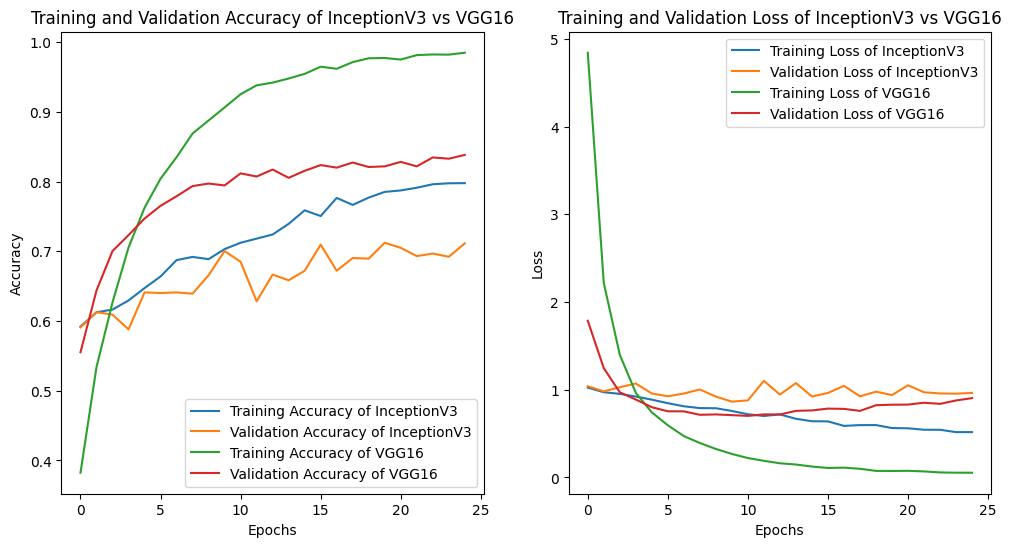

In [ ]:
# accuracy and loss
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

acc_vgg = history1.history['acc']
val_acc_vgg = history1.history['val_acc']
loss_vgg = history1.history['loss']
val_loss_vgg = history1.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy of InceptionV3')
plt.plot(epochs_range, val_acc, label='Validation Accuracy of InceptionV3')
plt.plot(epochs_range, acc_vgg, label='Training Accuracy of VGG16')
plt.plot(epochs_range, val_acc_vgg, label='Validation Accuracy of VGG16')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy of InceptionV3 vs VGG16')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss of InceptionV3')
plt.plot(epochs_range, val_loss, label='Validation Loss of InceptionV3')
plt.plot(epochs_range, loss_vgg, label='Training Loss of VGG16')
plt.plot(epochs_range, val_loss_vgg, label='Validation Loss of VGG16')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss of InceptionV3 vs VGG16')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()


# **Making Predictions**

1/1 [==============================] - 1s 1s/step


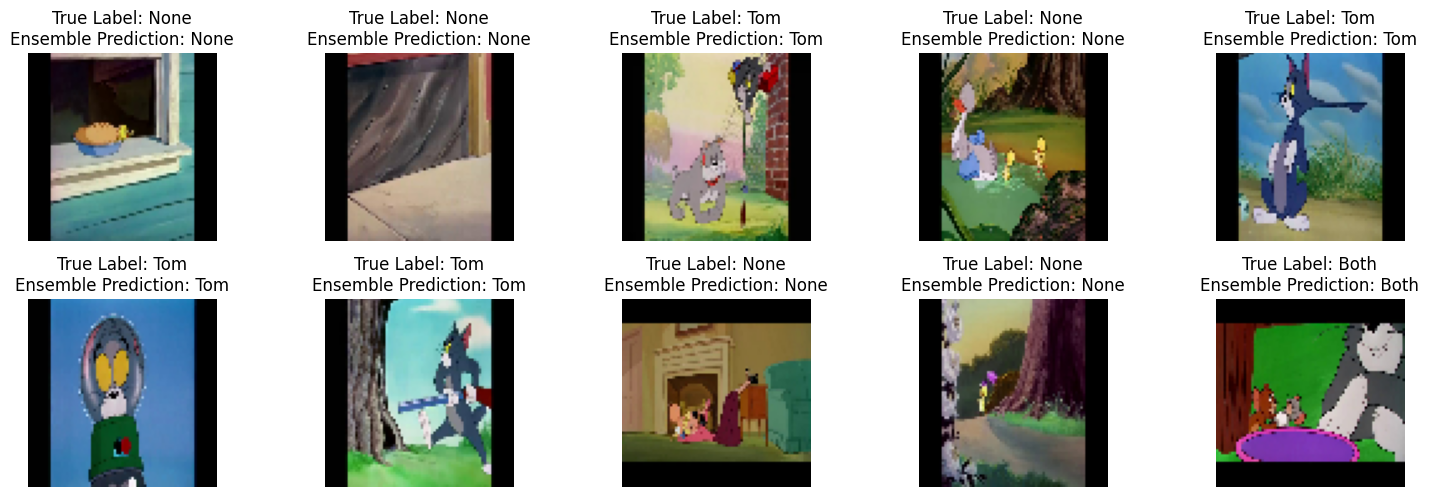

In [8]:
images = []
true_labels = []
for i, (batch_images, batch_labels) in enumerate(val_ds):
    images.extend(batch_images.numpy()[:10])
    true_labels.extend(batch_labels.numpy()[:10])
    if i == 0:
        break

# Generate predictions using the InceptionV3 model
inception_predictions = inception_trained.predict(np.array(images))

# Generate predictions using the VGG16 model
vgg16_predictions = vgg16_trained.predict(np.array(images))

# Combine predictions
ensemble_predictions = (inception_predictions + vgg16_predictions) / 2.0

# Decode label categories
label_categories = {
    0: "Jerry",
    1: "Tom",
    2: "None",
    3: "Both"
}

# Plot the first 10 images along with their true labels and ensemble predictions
plt.figure(figsize=(15, 10))  # Increase the height to accommodate 2 rows of images
num_images_to_plot = min(10, len(images))  # Determine the number of images to plot
for i in range(num_images_to_plot):
    ax = plt.subplot(4, 5, i + 1)
    plt.imshow(images[i].astype("uint8"))
    plt.title(f"True Label: {label_categories[true_labels[i]]}\n"
              f"Ensemble Prediction: {label_categories[np.argmax(ensemble_predictions[i])]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [9]:
true_labels = []
ensemble_predictions = []

# Iterate over the validation dataset to collect true labels and predictions from each model
for images, labels in val_ds:
    predictions_model1 = inception_trained.predict(images)
    predictions_model2 = vgg16_trained.predict(images)

    # ensemble predictions
    ensemble_pred = 0.5 * (predictions_model1 + predictions_model2)

    true_labels.extend(labels.numpy())
    ensemble_predictions.extend(np.argmax(ensemble_pred, axis=1))

# Convert true labels and ensemble predictions to NumPy arrays
true_labels_array = np.array(true_labels)
ensemble_predictions_array = np.array(ensemble_predictions)

print("Length of true_labels:", len(true_labels))
print("Length of ensemble_predictions:", len(ensemble_predictions))

1/1 [==============================] - 0s 341ms/step
Length of true_labels: 1095
Length of ensemble_predictions: 1095


# **Performance Metric**

In [10]:
true_labels = []
for _, labels in val_ds:
    true_labels.extend(labels.numpy())

ensemble_pred_labels = ensemble_predictions_array
report = classification_report(true_labels_array, ensemble_pred_labels, target_names=label_categories.values(), output_dict=True)
accuracy = report['accuracy']
print(report)

{'Jerry': {'precision': 0.8436018957345972, 'recall': 0.8165137614678899, 'f1-score': 0.8298368298368298, 'support': 218}, 'Tom': {'precision': 0.84375, 'recall': 0.8775, 'f1-score': 0.8602941176470588, 'support': 400}, 'None': {'precision': 0.7653958944281525, 'recall': 0.8365384615384616, 'f1-score': 0.7993874425727413, 'support': 312}, 'Both': {'precision': 0.9291338582677166, 'recall': 0.7151515151515152, 'f1-score': 0.8082191780821918, 'support': 165}, 'accuracy': 0.8292237442922374, 'macro avg': {'precision': 0.8454704121076166, 'recall': 0.8114259345394667, 'f1-score': 0.8244343920347055, 'support': 1095}, 'weighted avg': {'precision': 0.8342610218684009, 'recall': 0.8292237442922374, 'f1-score': 0.8290293355520633, 'support': 1095}}


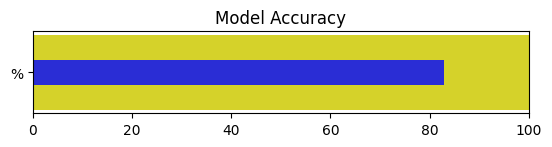

In [11]:
fig, ax = plt.subplots()

ax.barh([1], 100, left=0, height=15, color="#D5D22A")
ax.barh([1], accuracy * 100, height=5, color="#2A2DD5")

ax.set_aspect('equal')
ax.set_yticks([1])
ax.set_yticklabels(['%'])
ax.set_xlim(0, 100)
ax.set_title('Model Accuracy')

plt.show()

In [13]:
accuracy = report['accuracy']

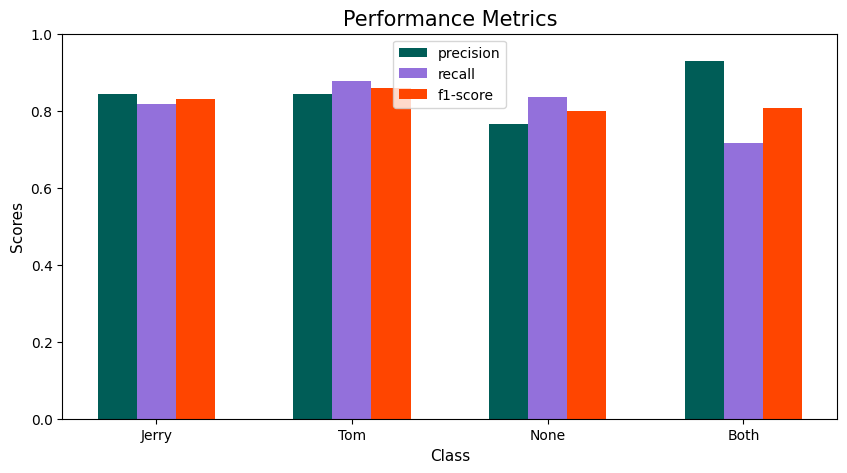

In [15]:
report = classification_report(true_labels_array, ensemble_pred_labels, target_names=label_categories.values(), output_dict=True)

metrics = ["precision", "recall", "f1-score"]

class_scores = []
for label, scores in report.items():
    if label in label_categories.values():  # Ensure the label is one of the categories
        class_scores.append([scores[metric] for metric in metrics])


fig, ax = plt.subplots(figsize=(10, 5))

bar_width = 0.2
for i, scores in enumerate(class_scores):
    ax.bar(i - bar_width, scores[0], bar_width, color="#005D57")
    ax.bar(i, scores[1], bar_width, color="#9370DB")
    ax.bar(i + bar_width, scores[2], bar_width, color="#FF4500")

ax.set_xlabel("Class", fontsize=11)
ax.set_ylabel("Scores", fontsize=11)
ax.set_ylim(0.0, 1.0)
ax.legend(metrics)
ax.set_xticks(np.arange(len(label_categories)))
ax.set_xticklabels(label_categories.values())
ax.set_title("Performance Metrics", fontsize=15)

plt.show()

# **Confusion Matrix**

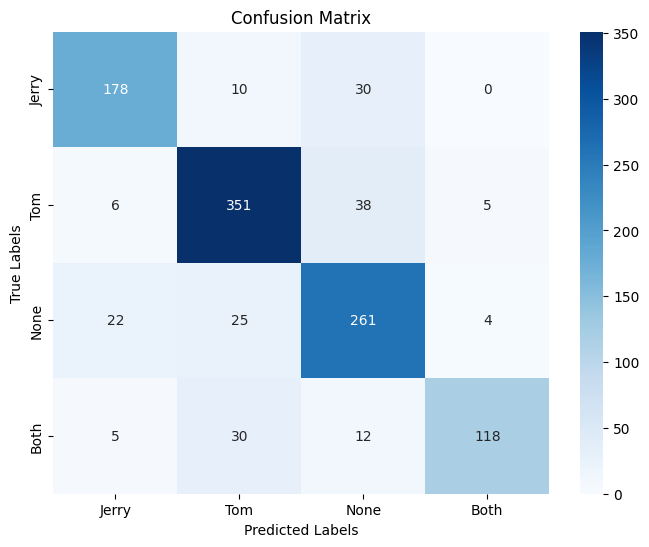

In [16]:
conf_matrix = confusion_matrix(true_labels_array, ensemble_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=label_categories.values(), yticklabels=label_categories.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# **Heatmap**

In [19]:
# Generate predictions using the InceptionV3 model
inception_predictions = inception_trained.predict(val_ds)

# Generate predictions using the VGG16 model
vgg16_predictions = vgg16_trained.predict(val_ds)

# Combine predictions using averaging (BOTH THE MODELS)
ensemble_predictions = (inception_predictions + vgg16_predictions) / 2.0

35/35 [==============================] - 66s 2s/step


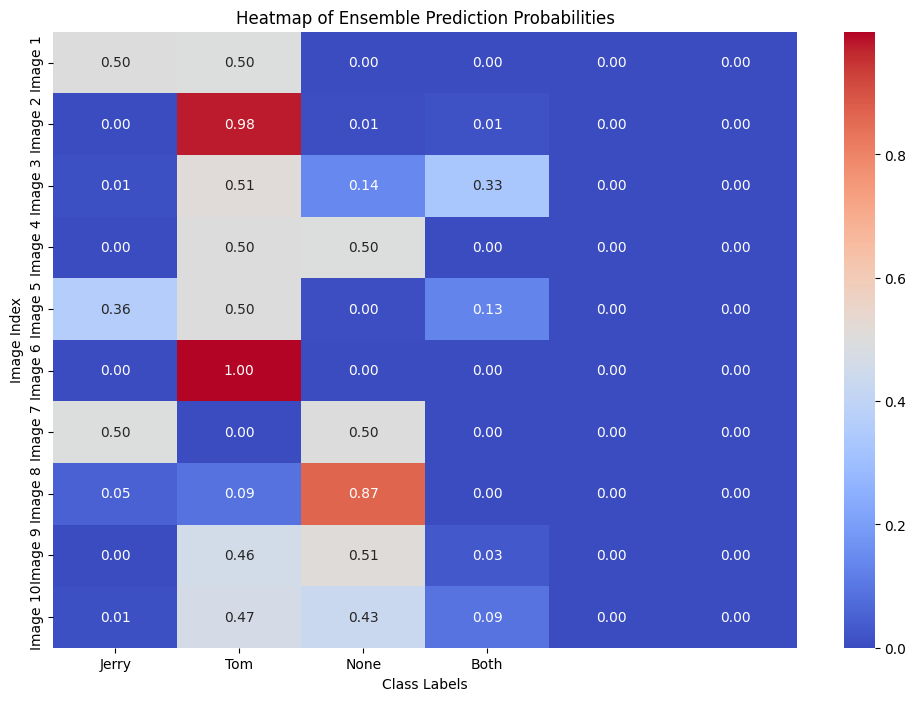

In [20]:
ensemble_probs = ensemble_predictions

plt.figure(figsize=(12, 8))
sns.heatmap(ensemble_probs[:10], annot=True, fmt=".2f", cmap="coolwarm",
            xticklabels=list(label_categories.values()),
            yticklabels=[f"Image {i+1}" for i in range(10)])  # FOR THE FIRST TEN PREDICTIONS
plt.xlabel("Class Labels")
plt.ylabel("Image Index")
plt.title("Heatmap of Ensemble Prediction Probabilities")
plt.show()

# **AUC-ROC (Area Under the Receiver Operating Characteristic Curve)**

AUC for Jerry: 0.48685573211427613
AUC for Tom: 0.4683525179856115
AUC for None: 0.5111278940301929
AUC for Both: 0.46124470511567284


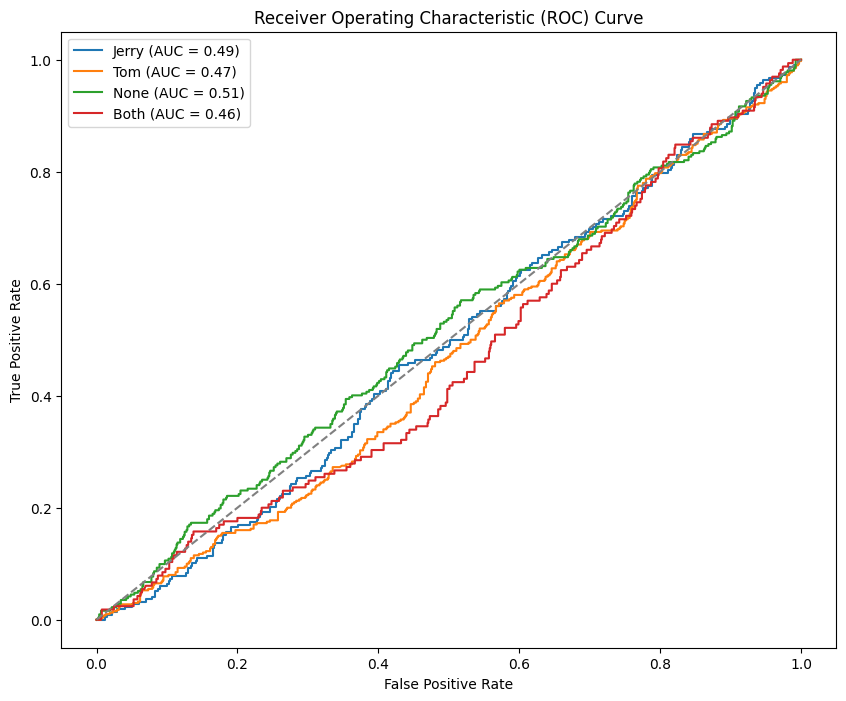

In [21]:
# Compute predicted probabilities for each class
ensemble_probabilities = np.array([1 - ensemble_predictions[:, i] if i == 2 else ensemble_predictions[:, i] for i in range(4)]).T

# Initialize dictionaries to store AUC scores and ROC curves
auc_scores = {}
roc_curves = {}

# Compute AUC scores and ROC curves for each class
for i, category in enumerate(label_categories.values()):
    true_labels_binary = (true_labels_array == i).astype(int)
    auc_scores[category] = roc_auc_score(true_labels_binary, ensemble_probabilities[:, i])
    fpr, tpr, _ = roc_curve(true_labels_binary, ensemble_probabilities[:, i])
    roc_curves[category] = (fpr, tpr)

for category, auc_score in auc_scores.items():
    print(f"AUC for {category}: {auc_score}")

plt.figure(figsize=(10, 8))
for category, (fpr, tpr) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{category} (AUC = {auc_scores[category]:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

The project achieved an accuracy of 82% in classifying images from the "Tom and Jerry" dataset, indicating a reasonably effective performance. This analysis will guide improvement strategies, such as fine-tuning model architectures or augmenting the dataset, to enhance classification accuracy and reliability for the "Tom and Jerry" images.

**Interpretation:**

* With an accuracy of 82%, the models demonstrate a reasonable level of effectiveness in distinguishing between different classes within the "Tom and Jerry" dataset.
* However, to gain deeper insights, it's crucial to examine precision and recall scores for each class individually. This analysis will help identify potential areas of improvement and provide context-specific feedback on the model's performance.
* In a classification task like this, precision is essential to minimize false positives, ensuring that when the model predicts Tom or Jerry, it's highly likely to be correct. Similarly, high recall ensures that the model captures most instances of Tom or Jerry in the dataset, avoiding false negatives.